In [1]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files=["data/train.csv", "data/eval.csv"])

Using custom data configuration default-a08bba800c97febe
Found cached dataset csv (/root/.cache/huggingface/datasets/csv/default-a08bba800c97febe/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'target'],
        num_rows: 6004
    })
})

In [6]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'target'],
        num_rows: 4803
    })
    test: Dataset({
        features: ['input', 'target'],
        num_rows: 1201
    })
})

In [7]:
# access a single 
dataset['train'][0]

{'input': "grammar: By just knowing culture of a different country that we are living and not born on, we won't be able to live.",
 'target': "But by just knowing the culture of a different country that we are living in but not born in, we won't be able to make a living."}

In [8]:
from transformers import AutoTokenizer
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
dataset['test'][0]

{'input': 'grammar: Thus, most of the habitant in the rural ereas are the old ones. ',
 'target': 'Thus, most of the habitats in rural areas are old ones. '}

In [10]:
def preprocess_func(examples):
    inputs = [source for source in examples['input']]
    targets = [target for target in examples['target']]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=1024, truncation=True)
    return model_inputs


To apply the preprocessing function over the entire dataset, use 🤗 Datasets map method. You can speed up the map function by setting batched=True to process multiple elements of the dataset at once:

In [11]:
tokenized_data = dataset.map(preprocess_func, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [12]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4803
    })
    test: Dataset({
        features: ['input', 'target', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1201
    })
})

Now create a batch of examples using DataCollatorForSeq2Seq. It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [13]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

#### For evalution
Including a metric during training is often helpful for evaluating your model’s performance. You can quickly load a evaluation method with the 🤗 Evaluate library. For this task, load the SacreBLEU metric (see the 🤗 Evaluate quick tour to learn more about how to load and compute a metric):

In [14]:
import evaluate
metric = evaluate.load("sacrebleu")

In [15]:
# Then create a function that passes your predictions and labels to compute to calculate the SacreBLEU score:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

##### Train

In [16]:
# Loading T5 Model
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, T5ForConditionalGeneration

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

##### Three steps remaining for training.
1. Define your training hyperparameters in Seq2SeqTrainingArguments. The only required parameter is output_dir which specifies where to save your model. You’ll push this model to the Hub by setting push_to_hub=True (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the Trainer will evaluate the SacreBLEU metric and save the training checkpoint.
2. Pass the training arguments to Seq2SeqTrainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.
3. Call train() to finetune your model.

In [19]:
training_args = Seq2SeqTrainingArguments(
    output_dir="trainer-state",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=100,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
    logging_dir="logging",
    logging_strategy="epoch"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [20]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input, target. If input, target are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 4803
  Num Epochs = 100
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 30100
  Number of trainable parameters = 60506624


Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input, target. If input, target are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1201
***** Running Evaluation *****
  Num examples = 1201
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config Genera

TrainOutput(global_step=30100, training_loss=0.4189558096343893, metrics={'train_runtime': 4882.0103, 'train_samples_per_second': 98.382, 'train_steps_per_second': 6.165, 'total_flos': 6526121397583872.0, 'train_loss': 0.4189558096343893, 'epoch': 100.0})

In [21]:
trainer.save_model("gec-t5-small")

Saving model checkpoint to gec-t5-small
Configuration saved in gec-t5-small/config.json
Configuration saved in gec-t5-small/generation_config.json
Model weights saved in gec-t5-small/pytorch_model.bin
tokenizer config file saved in gec-t5-small/tokenizer_config.json
Special tokens file saved in gec-t5-small/special_tokens_map.json


#### inference

In [22]:
from transformers import pipeline
corrector = pipeline("text2text-generation", model="gec-t5-small")

loading configuration file gec-t5-small/config.json
Model config T5Config {
  "_name_or_path": "gec-t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stoppin

In [34]:
text = "Yesterday I go to a supermrket to buy groceries."
correction = corrector(text)
correction[0]['generated_text']


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



'Yesterday I went to a supermarket to buy groceries.'

In [ ]:
# del model
# del trainer
# torch.cuda.empty_cache()

In [1]:
### Draw curve from log_history
import pandas as pd
df = pd.read_json(r"second-train\trainer-state\checkpoint-30000\trainer_state.json")

In [2]:
df['log_history']

0      {'epoch': 1.0, 'learning_rate': 1.98e-05, 'los...
1      {'epoch': 1.0, 'eval_bleu': 46.646, 'eval_gen_...
2      {'epoch': 2.0, 'learning_rate': 1.960000000000...
3      {'epoch': 2.0, 'eval_bleu': 47.6902, 'eval_gen...
4      {'epoch': 3.0, 'learning_rate': 1.94e-05, 'los...
                             ...                        
193    {'epoch': 97.0, 'eval_bleu': 53.0376, 'eval_ge...
194    {'epoch': 98.0, 'learning_rate': 4e-07, 'loss'...
195    {'epoch': 98.0, 'eval_bleu': 53.0287, 'eval_ge...
196    {'epoch': 99.0, 'learning_rate': 2e-07, 'loss'...
197    {'epoch': 99.0, 'eval_bleu': 53.0546, 'eval_ge...
Name: log_history, Length: 198, dtype: object

In [27]:
df['log_history'][0]

{'epoch': 1.0, 'learning_rate': 1.98e-05, 'loss': 0.9886, 'step': 301}

In [28]:
df['log_history'][0]['epoch']

1.0

In [3]:
epochs = []
eval_bleu = []
eval_loss = []
train_loss = []
for log in df['log_history']:
    epochs.append(int(log['epoch']))
    if 'eval_bleu' in log:
        eval_bleu.append(log['eval_bleu'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'loss' in log:
        train_loss.append(log['loss'])

In [4]:
len(epochs)

198

In [5]:
epochs = list(set(epochs))
len(epochs)

99

In [6]:
max(eval_bleu)

53.3029

In [7]:
min(train_loss)

0.32070000000000004

In [8]:
min(eval_loss)

0.531223654747009

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

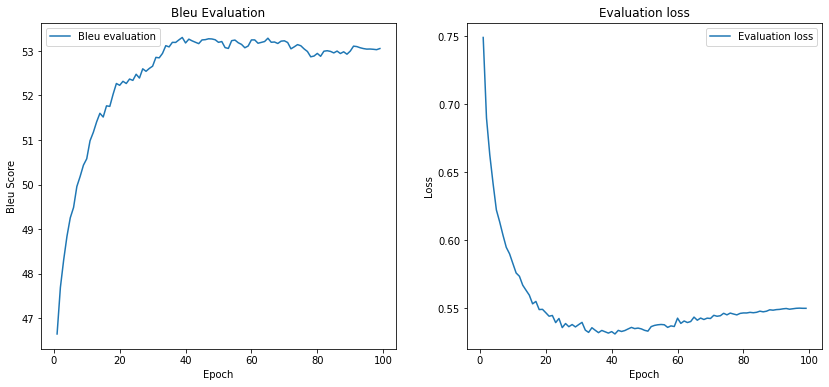

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# epochs vs eval_blue
ax[0].plot(epochs, eval_bleu, label="Bleu evaluation")
ax[0].set_title("Bleu Evaluation")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Bleu Score")
ax[0].legend()

## epochs vs eval_loss
ax[1].plot(epochs, eval_loss, label="Evaluation loss" )
ax[1].set_title("Evaluation loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()